In [148]:
# Essencial Libraries
import pandas as pd
import os
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from typing import Optional, Tuple, List, Union
import matplotlib.patches as mpatches

In [149]:
# CCT Dublin color palette
COR_1 = "#00558C"  # deep blue (primary)
COR_2 = "#0099D8"  # light blue (accent)
COR_3 = "#78BE20"  # green (support)
COR_CINZA = "#A7A8AA"  # soft grey


def plot_bivariate_distribution(
    df: pd.DataFrame,
    analysis_variable: str,
    target_variable: str,
    spam_ratio: float,
    convert_str: Optional[bool] = True,
    sort_values: Optional[bool] = False,
    figsize: Optional[Tuple[int, int]] = (16, 4),
    bar_width: Optional[float] = 0.3,
    y_labelsize: Optional[int] = 10,
    yticks_labelsize: Optional[int] = 10,
    show_line_labels: Optional[bool] = True,
    show_bar_labels: Optional[bool] = False,
    label_fontsize: Optional[int] = 9,
    rotation: Optional[int] = 45,
    ha: Optional[str] = 'right',
    is_category_axes: Optional[bool] = False,
    custom_xticks: Optional[Union[None, List[str]]] = None,
    ncol: Optional[int] = 4,
    bbox_to_anchor: Optional[Tuple[float, float, float, float]] = (0, 1.08, 1., .1),
    leg_fontsize: Optional[int] = 10,
    title_fontsize: Optional[int] = 14,
    title_pad: Optional[int] = 40,
    xticks_labelsize: Optional[int] = 10,
    title: Optional[str] = None,  # Fix: Default to None
    label1: str = "Spam",
    label2: str = "Non-Spam"
) -> None:

    # Fix: Define title inside the function
    if title is None:
        title = f'Spam ratio variation by variable: {analysis_variable}'

    df_tmp = df[[analysis_variable, target_variable]].copy()
    df_tmp['quantity'] = 1

    if convert_str:
        df_tmp[analysis_variable] = df_tmp[analysis_variable].astype(str)

    df_tmp = df_tmp.groupby(analysis_variable)[['quantity', target_variable]].sum().reset_index()

    if sort_values:
        df_tmp.sort_values(by=['quantity'], ascending=False, inplace=True)
    else:
        df_tmp.sort_values(by=[analysis_variable], inplace=True)

    df_tmp['non_event_count'] = (df_tmp['quantity'] - df_tmp[target_variable]).astype(int)
    df_tmp['event_ratio'] = df_tmp[target_variable] / df_tmp['quantity']
    df_tmp['perc_distribution'] = 100 * df_tmp['quantity'] / df_tmp['quantity'].sum()
    df_tmp[target_variable] = df_tmp[target_variable].astype(int)

    fig, ax1 = plt.subplots(figsize=figsize)
    x_loc = np.arange(len(df_tmp))

    # Plot bar chart
    ax1.bar(x_loc - bar_width / 2, df_tmp[target_variable], width=bar_width, color=COR_1,
            linestyle='-', linewidth=4., alpha=0.6, label=label1)
    y1_b1_patch = mpatches.Patch(color=COR_1, label=label1, alpha=0.5)

    ax1.bar(x_loc + bar_width / 2, df_tmp['non_event_count'], width=bar_width, color=COR_2,
            linestyle='-', linewidth=4., alpha=0.6, label=label2)
    y1_b2_patch = mpatches.Patch(color=COR_2, label=label2, alpha=0.5)

    plt.ylabel('Transaction count', fontsize=y_labelsize)

    if show_bar_labels:
        for idx, bar in enumerate(ax1.patches):
            if idx < len(df_tmp):
                bar_value = bar.get_height()
                text_x = bar.get_x() + bar.get_width() / 2
                text_y = bar.get_y() + bar_value
                ax1.text(text_x, text_y, bar_value, ha='center', va='bottom', color='black', fontsize=label_fontsize)

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    ax1.yaxis.grid(True, linestyle='--', which='major', color=COR_CINZA, alpha=.25)
    plt.gcf().autofmt_xdate(rotation=rotation, ha=ha)

    margin = (1 - bar_width) + bar_width / 2
    ax1.set_xlim(-margin, len(df_tmp) - 1 + margin)
    ax1.tick_params(axis='x', labelsize=xticks_labelsize)

    if is_category_axes:
        plt.xticks(df_tmp[analysis_variable])
    if custom_xticks:
        plt.xticks(np.arange(0, len(custom_xticks)).tolist(), custom_xticks)

    # Plot line chart for event ratio
    ax2 = ax1.twinx()
    y_values = round(100.00 * df_tmp['event_ratio'], 2)

    ax2.plot(
        df_tmp[analysis_variable], y_values,
        linestyle='-', marker='.',
        linewidth=1, color=COR_3
    )

    y2_patch = mpatches.Patch(color=COR_3, label="Event ratio")

    plt.ylabel("Event ratio [%]", fontsize=y_labelsize)
    ax2.set_ylim([0, round(y_values.max() * 1.1, 2)])

    if show_line_labels:
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        for x, y in enumerate(y_values):
            ax2.text(x, y + (y*0.02), f'{round(y, 2)}%',
                     ha='center', va='bottom',
                     color=COR_3, weight='bold', bbox=props)

    # Plot fraud ratio reference line
    spam_ratio_fmt = round(100 * spam_ratio, 2)
    plt.axhline(spam_ratio_fmt, color=COR_CINZA, linestyle='--', alpha=0.7)
    base_patch = mpatches.Patch(color=COR_CINZA, label=f'Spam ratio: {spam_ratio_fmt}%')

    plt.legend(
        loc='upper center',
        ncol=ncol,
        bbox_to_anchor=bbox_to_anchor,
        borderaxespad=0.5,
        frameon=False,
        handles=[base_patch, y2_patch, y1_b1_patch, y1_b2_patch],
        fontsize=leg_fontsize
    )

    plt.title(
        title,
        fontsize=title_fontsize,
        weight='medium',
        pad=title_pad,
    )

    sns.despine(right=False)
    plt.show()

In [89]:
file_path = r'C:\Users\erikg\Documents\GitHub\ml-ca1-Erik2021374\spambase_v6.csv'
df = pd.read_csv(file_path)
df.head()

Unnamed: 0  word_freq_make word_freq_address  word_freq_all  word_freq_3d  \
0           0            0.00              0.64           0.64           0.0   
1           1            0.21              0.28           0.50           0.0   
2           2            0.06                 0           0.71           0.0   
3           3            0.00                 0           0.00           0.0   
4           4            0.00                 0           0.00           0.0   

  word_freq_our  word_freq_over word_freq_remove word_freq_internet  \
0          0.32            0.00                0                  0   
1          0.14            0.28             0.21               0.07   
2          1.23            0.19             0.19               0.12   
3          0.63            0.00             0.31               0.63   
4          0.63            0.00             0.31               0.63   

   word_freq_order  ...  char_freq_;  char_freq_(  char_freq_[  char_freq_!  \
0             0.00  ...         0.00        0.000          0.0        0.778   
1             0.00  ...         0.00        0.132          0.0        0.372   
2             0.64  ...         0.01        0.143          0.0        0.276   
3             0.31  ...         0.00        0.137          0.0        0.137   
4             0.31  ...         0.00        0.135          0.0        0.135   

  char_freq_$ char_freq_#  capital_run_length_average  \
0       0.000       0.000                       3.756   
1       0.180       0.048                       5.114   
2       0.184       0.010                       9.821   
3       0.000       0.000                       3.537   
4       0.000       0.000                       3.537   

   capital_run_length_longest  capital_run_length_total  is_spam  
0                          61                       278     True  
1                         101                      1028     True  
2                         485                      2259     True  
3                          40                       191     True  
4                          40                       191     True  

[5 rows x 59 columns]

In [90]:
# Drop the 'Unnamed: 0' column if it exists
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

df = df.reset_index(drop=True)

In [143]:
#Setting variables of interest
spam = 'is_spam'
df[spam] = df[spam].astype(int)

#Tax of spam in the base
tax_spam = df[spam].mean()
event = df[spam].sum()
non_event = len(df) - event

print(f'There are {event} cases of spam and {non_event} of non events')
print(f'That value creates a tax basis of {tax_spam}')
print(f'So, one event is a spam for each {round(1/tax_spam)} analysed')

There are 1813 cases of spam and 2788 of non events
That value creates a tax basis of 0.39404477287546186
So, one event is a spam for each 3 analysed


In [92]:
print("Dataset Size:", df.shape)
print("\nData Types:")
print(df.dtypes)

Dataset Size: (4601, 58)

Data Types:
word_freq_make                float64
word_freq_address              object
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                  object
word_freq_over                float64
word_freq_remove               object
word_freq_internet             object
word_freq_order               float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report               object
word_freq_addresses            object
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                  object
word_freq_money               float64
word_freq_hp                  float64
word_freq_hp

In [93]:
# Check for duplicated rows
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Check for NaN values per column
print("Number of NaN values per column:\n", df.isna().sum())

# Print total number of NaN values in the entire dataset
total_nans = df.isna().sum().sum()
print(f"\nTotal number of NaN values in dataset: {total_nans}")


Number of duplicate rows: 376
Number of NaN values per column:
 word_freq_make                  0
word_freq_address               0
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   0
word_freq_over                  1
word_freq_remove                0
word_freq_internet             15
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                0
word_freq_addresses             9
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   0
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   0
word_freq_george                0
word_freq_650    

In [94]:
# List of object-type columns to check for non-numeric values
object_cols = [
    "word_freq_address", "word_freq_our", "word_freq_remove", "word_freq_internet", 
    "word_freq_report", "word_freq_addresses", "word_freq_000", "word_freq_hpl", 
    "word_freq_labs"
]

# Check for non-numeric values in each object-type column
for col in object_cols:
    non_numeric_values = df[col][~df[col].astype(str).str.match(r'^-?\d+(\.\d+)?$', na=False)]
    if not non_numeric_values.empty:
        print(f"Column '{col}' contains non-numeric values:")
        print(non_numeric_values.unique(), "\n")


Column 'word_freq_address' contains non-numeric values:
['zero'] 

Column 'word_freq_our' contains non-numeric values:
['???'] 

Column 'word_freq_remove' contains non-numeric values:
['?'] 

Column 'word_freq_internet' contains non-numeric values:
[nan '?'] 

Column 'word_freq_report' contains non-numeric values:
['zero'] 

Column 'word_freq_addresses' contains non-numeric values:
[nan 'zero'] 

Column 'word_freq_000' contains non-numeric values:
['???'] 

Column 'word_freq_hpl' contains non-numeric values:
['none'] 

Column 'word_freq_labs' contains non-numeric values:
[nan 'no'] 



In [95]:
# Display percentage of missing values per column, only for columns with missing values
missing_values = (df.isnull().mean() * 100).loc[lambda x: x > 0].sort_values(ascending=False)
print("\nPercentage of missing values per column:")
print(missing_values)


Percentage of missing values per column:
word_freq_labs         5.433601
word_freq_table        0.869376
word_freq_internet     0.326016
word_freq_cs           0.304282
word_freq_addresses    0.195610
word_freq_all          0.130406
word_freq_direct       0.065203
word_freq_3d           0.043469
word_freq_over         0.021734
word_freq_meeting      0.021734
dtype: float64


In [96]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Categorical Variables: {categorical_cols}\n")
print(f"Numerical Variables: {numerical_cols}\n")

Categorical Variables: ['word_freq_address', 'word_freq_our', 'word_freq_remove', 'word_freq_internet', 'word_freq_report', 'word_freq_addresses', 'word_freq_000', 'word_freq_hpl', 'word_freq_labs']

Numerical Variables: ['word_freq_make', 'word_freq_all', 'word_freq_3d', 'word_freq_over', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_money', 'word_freq_hp', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_

In [97]:
# Frequency of unique items in categorical variables
if categorical_cols:
    for col in categorical_cols:
        print(f"\nValue Counts for {col}:\n{df[col].value_counts()}\n")
else:
    print("No categorical variables found.\n")


Value Counts for word_freq_address:
word_freq_address
0        3702
14.28      35
0.08       27
0.1        24
0.17       24
         ... 
1.2         1
0.96        1
2.4         1
2.46        1
2.01        1
Name: count, Length: 172, dtype: int64


Value Counts for word_freq_our:
word_freq_our
0       2852
0.36      28
0.32      26
0.19      24
0.8       24
        ... 
2.03       1
1.72       1
2.9        1
1.9        1
1.96       1
Name: count, Length: 256, dtype: int64


Value Counts for word_freq_remove:
word_freq_remove
0       3793
0.08      30
0.05      21
0.5       19
0.32      19
        ... 
0.85       1
0.75       1
2.35       1
2.46       1
0.88       1
Name: count, Length: 174, dtype: int64


Value Counts for word_freq_internet:
word_freq_internet
0       3761
0.05      24
0.18      21
0.32      20
0.1       20
        ... 
0.68       1
1.65       1
2.94       1
0.66       1
?          1
Name: count, Length: 171, dtype: int64


Value Counts for word_freq_report:
word_freq

In [66]:
# Basic statistics for numerical variables
print(f"Basic Statistics for Numerical Variables:\n{df[numerical_cols].describe()}\n")

Basic Statistics for Numerical Variables:
       word_freq_make  word_freq_all  word_freq_3d  word_freq_over  \
count     4601.000000    4595.000000   4599.000000     4600.000000   
mean         0.104553       0.281023      0.065453        0.095922   
std          0.305358       0.504370      1.395454        0.273850   
min          0.000000       0.000000      0.000000        0.000000   
25%          0.000000       0.000000      0.000000        0.000000   
50%          0.000000       0.000000      0.000000        0.000000   
75%          0.000000       0.420000      0.000000        0.000000   
max          4.540000       5.100000     42.810000        5.880000   

       word_freq_order  word_freq_mail  word_freq_receive  word_freq_will  \
count      4601.000000     4601.000000        4601.000000     4601.000000   
mean          0.090067        0.239413           0.059824        0.541702   
std           0.278616        0.644755           0.201545        0.861698   
min           0.000

In [67]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()[:10]}")  # Show first unique values

word_freq_address: ['0.64' '0.28' '0' '0.12' '0.69' '0.42' '0.63' '0.07' '0.68' '0.48']
word_freq_our: ['0.32' '0.14' '1.23' '0.63' '1.85' '1.92' '1.88' '0.61' '0.19' '0']
word_freq_remove: ['0' '0.21' '0.19' '0.31' '0.3' '0.38' '0.96' '0.25' '0.9' '0.42']
word_freq_internet: ['0' '0.07' '0.12' '0.63' '1.85' '1.88' '0.35' nan '0.02' '2.45']
word_freq_report: ['0' '0.21' '0.06' '1.23' '0.23' '0.3' '0.37' '1.26' '1.27' '4.76']
word_freq_addresses: ['0' '0.14' '1.75' '0.12' '0.18' '1.27' nan '0.3' '0.26' '0.03']
word_freq_000: ['0' '0.43' '1.16' '0.19' '0.35' '0.7' '0.31' '0.05' '0.48' '0.3']
word_freq_hpl: ['0' '0.34' '0.05' '1.49' '0.21' '0.39' '0.1' '0.44' '0.51' '0.04']
word_freq_labs: [nan '0.39' '0' '0.06' '0.66' '2.24' '0.24' '3.38' '0.97' '0.86']


In [82]:
# Identify categorical variables (only object types)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Identify categorical variables that can be transformed directly (10 or fewer unique values)
transformable_categorical = [col for col in categorical_cols if df[col].nunique() <= 10]

# Print the results
print(f"Categorical Variables Suitable for Direct Transformation: {transformable_categorical}\n")


Categorical Variables Suitable for Direct Transformation: []



In [98]:
# Define a function to clean and convert
def safe_convert(val):
    if isinstance(val, str):
        val = val.lower().strip()  # Normalize case and strip spaces
        if val in ["zero"]:  # Replace known non-numeric values
            return 0.0  # Or use np.nan if you prefer missing values
        if val in ["?", "none"]:
            return np.nan  # Use np.nan instead of NaN
    
    try:
        return float(val)  # Convert valid numbers
    except ValueError:
        return np.nan  # Handle unexpected cases

# Convert boolean to integer
df["is_spam"] = df["is_spam"].astype(int)

# Apply the conversion to all object columns
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').applymap(safe_convert)

# Check for NaN values per column
print("Number of NaN values per column:\n", df.isna().sum())

# Print total number of NaN values in the dataset
total_nans = df.isna().sum().sum()
print(f"\nTotal number of NaN values in dataset: {total_nans}")


Number of NaN values per column:
 word_freq_make                  0
word_freq_address               0
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   1
word_freq_over                  1
word_freq_remove                1
word_freq_internet             16
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                0
word_freq_addresses             9
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   1
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   1
word_freq_george                0
word_freq_650                   0
word_freq_lab 

In [100]:
# Identify columns that should be numerical
expected_numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# Check for non-numeric values in columns expected to be numerical
for col in df.columns:
    non_numeric_values = df[col][~df[col].astype(str).str.replace('.', '', 1).str.isnumeric()]
    
    if not non_numeric_values.empty:
        print(f"Column: {col}")
        print(f"Non-Numeric Values Found: {non_numeric_values.unique()}\n")

Column: word_freq_all
Non-Numeric Values Found: [nan]

Column: word_freq_3d
Non-Numeric Values Found: [nan]

Column: word_freq_our
Non-Numeric Values Found: [nan]

Column: word_freq_over
Non-Numeric Values Found: [nan]

Column: word_freq_remove
Non-Numeric Values Found: [nan]

Column: word_freq_internet
Non-Numeric Values Found: [nan]

Column: word_freq_addresses
Non-Numeric Values Found: [nan]

Column: word_freq_000
Non-Numeric Values Found: [nan]

Column: word_freq_hpl
Non-Numeric Values Found: [nan]

Column: word_freq_labs
Non-Numeric Values Found: [nan]

Column: word_freq_direct
Non-Numeric Values Found: [nan]

Column: word_freq_cs
Non-Numeric Values Found: [nan]

Column: word_freq_meeting
Non-Numeric Values Found: [nan]

Column: word_freq_table
Non-Numeric Values Found: [nan]



In [71]:
print(df) # hcecking if all the columns

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0.00               0.64           0.64           0.0   
1               0.21               0.28           0.50           0.0   
2               0.06               0.00           0.71           0.0   
3               0.00               0.00           0.00           0.0   
4               0.00               0.00           0.00           0.0   
...              ...                ...            ...           ...   
4596            0.31               0.00           0.62           0.0   
4597            0.00               0.00           0.00           0.0   
4598            0.30               0.00           0.30           0.0   
4599            0.96               0.00           0.00           0.0   
4600            0.00               0.00           0.65           0.0   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0              0.32            0.00              0.00     

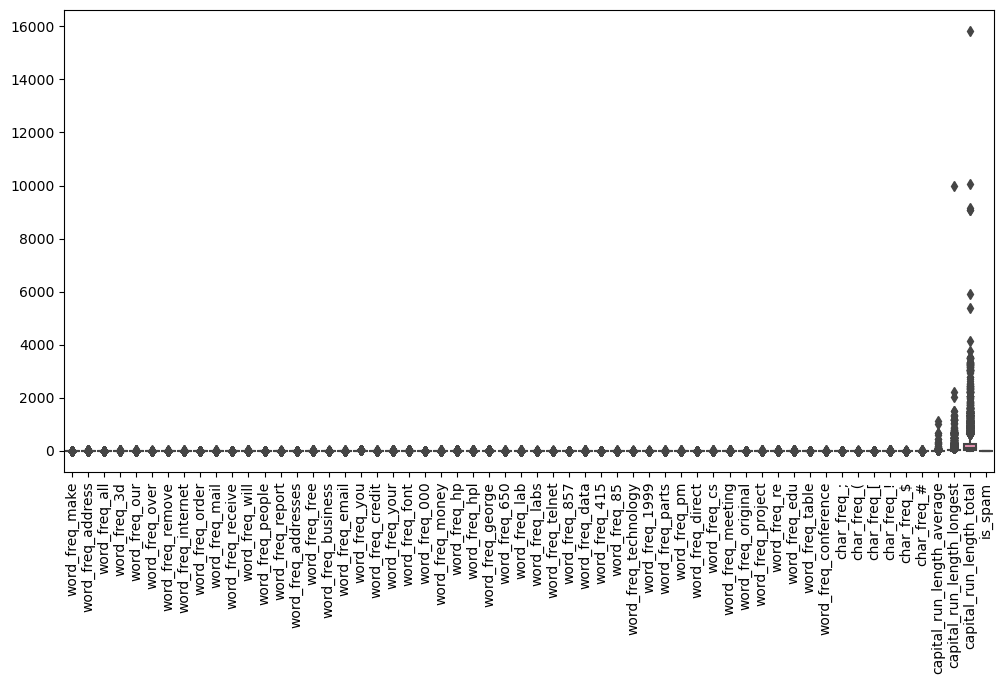

In [72]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)  # Rotate column names if needed
plt.show()

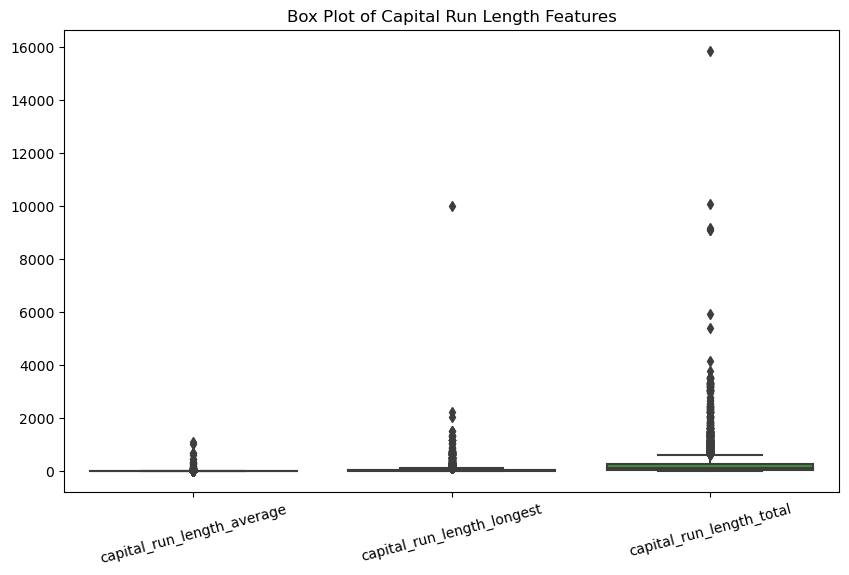

In [77]:
# Define the columns of interest
columns_to_plot = ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]

# Set figure size
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(data=df[columns_to_plot])

# Add title
plt.title("Box Plot of Capital Run Length Features")

# Rotate x-axis labels if needed
plt.xticks(rotation=15)

# Show plot
plt.show()

In [80]:
# Calculate Z-Scores
z_scores = np.abs(stats.zscore(df))

# Identify outliers (Z > 3)
outliers_z = z_scores > 3

# Count how many outliers exist per column
outliers_z_count = pd.Series(outliers_z.sum(axis=0), index=df.columns)

# Show only columns with outliers, sorted in descending order
print(outliers_z_count[outliers_z_count > 0].sort_values(ascending=False))

word_freq_george              123
word_freq_order               113
word_freq_original            107
word_freq_650                 107
word_freq_report              106
word_freq_email               106
word_freq_1999                105
word_freq_will                102
word_freq_receive             100
word_freq_business             97
word_freq_make                 90
word_freq_people               89
word_freq_your                 87
word_freq_hp                   86
capital_run_length_total       86
word_freq_85                   82
word_freq_data                 77
word_freq_technology           77
word_freq_credit               76
word_freq_mail                 74
word_freq_edu                  74
word_freq_free                 69
word_freq_pm                   69
capital_run_length_longest     68
word_freq_re                   64
word_freq_lab                  64
char_freq_$                    62
word_freq_telnet               61
word_freq_you                  60
word_freq_font

In [81]:
# Calcular Q1, Q3 e IQR para cada coluna numérica
df.columns = df.select_dtypes(include=[np.number]).columns
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = ((df< lower_bound) | (df > upper_bound))

# Exibir as colunas e quantidades de outliers detectados
outliers_count = outliers.sum()
print(outliers_count[outliers_count > 0].sort_values(ascending=False))

word_freq_hp                  1090
word_freq_make                1053
word_freq_email               1038
word_freq_re                  1001
word_freq_over                 999
word_freq_business             963
word_freq_free                 957
word_freq_address              898
word_freq_mail                 852
word_freq_people               852
word_freq_1999                 829
word_freq_internet             824
word_freq_hpl                  811
char_freq_$                    811
word_freq_remove               807
char_freq_;                    790
word_freq_george               780
word_freq_order                773
char_freq_#                    750
word_freq_money                735
word_freq_receive              709
word_freq_000                  679
word_freq_technology           599
capital_run_length_total       550
char_freq_[                    529
word_freq_edu                  517
word_freq_our                  501
word_freq_85                   485
word_freq_labs      

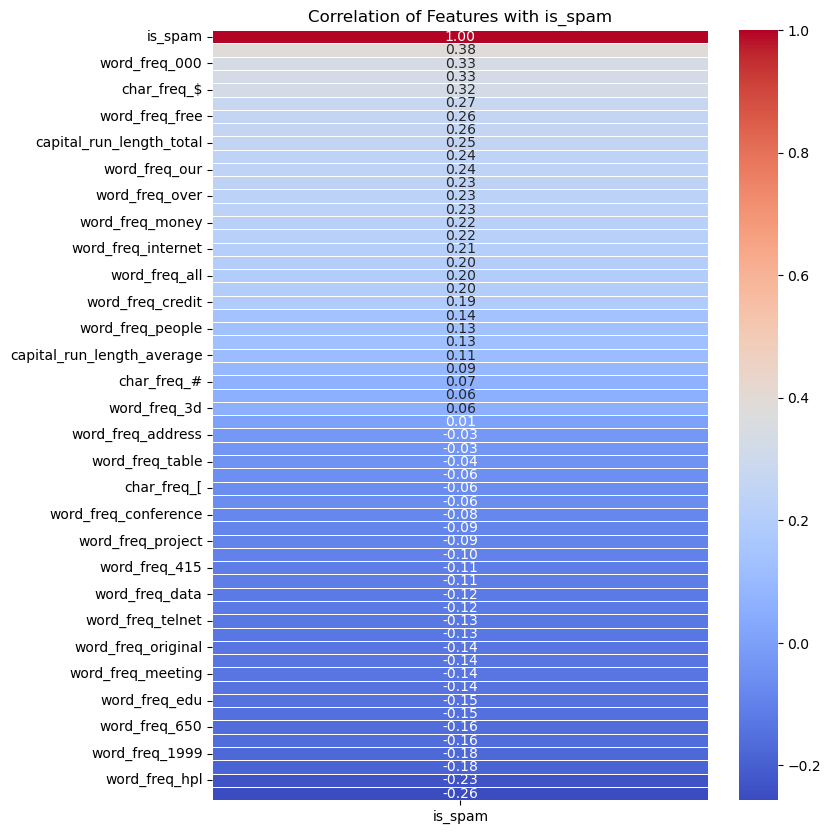

In [76]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Filter correlations only with 'is_spam'
corr_with_target = correlation_matrix[["is_spam"]].sort_values(by="is_spam", ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 10))  # Adjust figure size
sns.heatmap(corr_with_target, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Title
plt.title("Correlation of Features with is_spam")
plt.show()

# Rodar WoE, IV e IM

In [104]:
# Function to calculate WoE and IV
def calculate_woe_iv(df, feature, target):
    df = df[[feature, target]].copy()
    df["bin"] = pd.qcut(df[feature], q=10, duplicates='drop')  # Binning (adjust bins if needed)
    
    grouped = df.groupby("bin")[target].agg(["count", "sum"])  # Group by bins
    grouped["non_events"] = grouped["count"] - grouped["sum"]  # Count of non-events
    grouped["event_rate"] = grouped["sum"] / grouped["count"]  # Event rate
    
    # Avoid division by zero
    grouped["woe"] = np.log((grouped["sum"] / grouped["sum"].sum()) / (grouped["non_events"] / grouped["non_events"].sum()))
    grouped["woe"] = grouped["woe"].replace({np.inf: 0, -np.inf: 0})  # Replace infinite values
    
    # Calculate IV
    grouped["iv"] = (grouped["woe"] * ((grouped["sum"] / grouped["sum"].sum()) - (grouped["non_events"] / grouped["non_events"].sum())))
    iv = grouped["iv"].sum()
    
    return grouped[["woe", "iv"]], iv

# Apply WoE & IV calculation for all numeric features
target_var = "is_spam"  # Change this if your target variable has a different name
iv_values = {}

for col in df.select_dtypes(include=np.number).columns:
    if col != target_var:
        _, iv = calculate_woe_iv(df, col, target_var)
        iv_values[col] = iv

# Convert IV results to DataFrame and sort
iv_df = pd.DataFrame(list(iv_values.items()), columns=["Feature", "IV"]).sort_values(by="IV", ascending=False)
print("\nInformation Value (IV) Ranking:\n", iv_df)


Information Value (IV) Ranking:
                        Feature        IV
52                 char_freq_$  1.687796
51                 char_freq_!  1.579852
55  capital_run_length_longest  1.470283
54  capital_run_length_average  1.265119
24                word_freq_hp  1.264887
20              word_freq_your  1.226585
56    capital_run_length_total  1.112353
26            word_freq_george  0.964484
15              word_freq_free  0.955496
22               word_freq_000  0.954616
6             word_freq_remove  0.863035
18               word_freq_you  0.718752
23             word_freq_money  0.705876
4                word_freq_our  0.609356
25               word_freq_hpl  0.571344
2                word_freq_all  0.529724
16          word_freq_business  0.512472
29              word_freq_labs  0.451087
5               word_freq_over  0.435158
10           word_freq_receive  0.410206
17             word_freq_email  0.352920
34                word_freq_85  0.349835
45               word_f

In [109]:
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)
    
print(df.isnull().sum().sum())  # Should be 0 now


0


In [110]:
# Calculate Mutual Information
X = df.drop(columns=[target_var])  # Features
y = df[target_var]  # Target variable

mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual Information": mi_scores}).sort_values(by="Mutual Information", ascending=False)
print("\nMutual Information Ranking:\n", mi_df)


Mutual Information Ranking:
                        Feature  Mutual Information
51                 char_freq_!            0.210863
55  capital_run_length_longest            0.201803
52                 char_freq_$            0.179903
54  capital_run_length_average            0.172678
20              word_freq_your            0.171881
6             word_freq_remove            0.151288
56    capital_run_length_total            0.142731
15              word_freq_free            0.134296
23             word_freq_money            0.119161
24                word_freq_hp            0.118050
18               word_freq_you            0.111397
26            word_freq_george            0.106385
22               word_freq_000            0.098947
4                word_freq_our            0.097289
25               word_freq_hpl            0.082761
2                word_freq_all            0.078080
10           word_freq_receive            0.076920
16          word_freq_business            0.072040
1

1. char_freq_!

    IV: 1.579852
    MI: 0.210863
    
2. capital_run_length_longest

    IV: 1.470283
    MI: 0.201803

3. char_freq_$

    IV: 1.687796
    MI: 0.179903

4. capital_run_length_average

    IV: 1.265119
    MI: 0.172678

5. word_freq_your

    IV: 1.226585
    MI: 0.171881
    
6. word_freq_remove

    IV: 0.863035
    MI: 0.151288
    
# Key Findings:

Variables with Strong Positive Correlation with is_spam:

word_freq_free: 0.26
word_freq_your: 0.30
word_freq_money: 0.22

Variables with Moderate Positive Correlation:

capital_run_length_average: 0.27
capital_run_length_total: 0.24
word_freq_business: 0.20

## Heat Maps

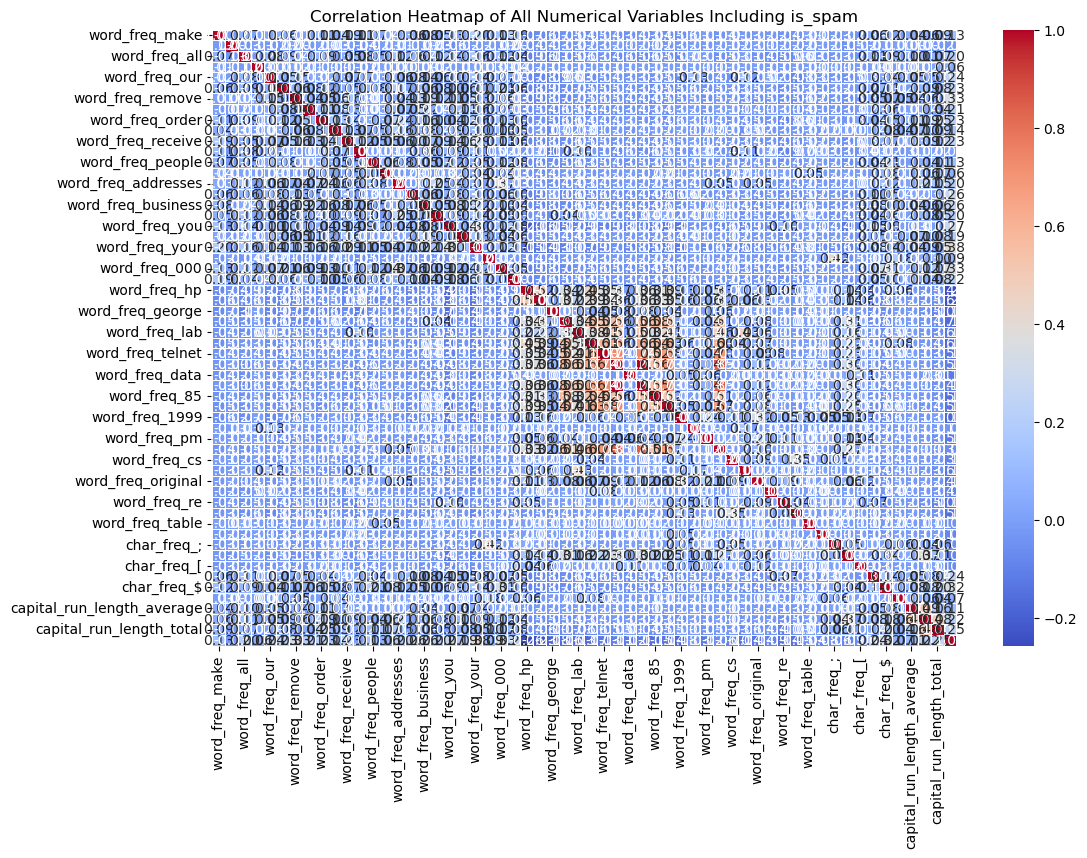

In [113]:
# Ensure 'is_spam' is included
df['is_spam'] = df['is_spam'].astype(int)  # Ensure it's binary (0,1)

# Select all numerical variables + 'is_spam'
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of All Numerical Variables Including is_spam")
plt.show()

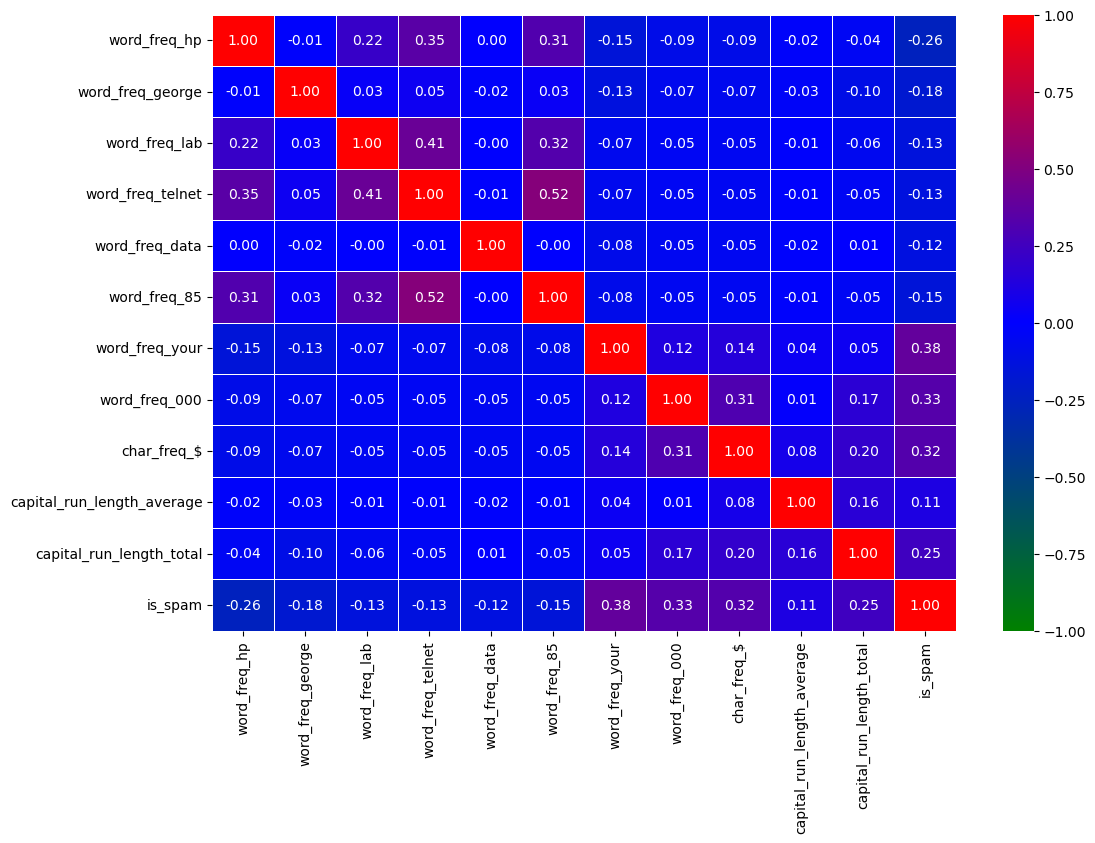

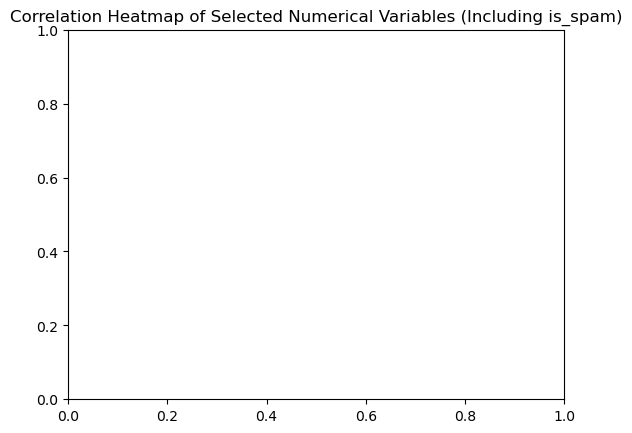

In [133]:

# Ensure 'is_spam' is numeric
df['is_spam'] = df['is_spam'].astype(int)

# Define custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom', ['green', 'blue', 'red'], N=256)

# Selected numerical variables + target variable
selected_vars = [
    "word_freq_hp", "word_freq_george", "word_freq_lab", "word_freq_telnet", 
    "word_freq_data", "word_freq_85", "word_freq_your", "word_freq_000", 
    "char_freq_$", "capital_run_length_average", "capital_run_length_total", "is_spam"
]

# Compute correlation matrix
correlation_matrix = df[selected_vars].corr()

# Normalize correlation values to fit into colormap
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = plt.cm.colors.BoundaryNorm(bounds, custom_cmap.N)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=custom_cmap, linewidths=0.5, vmin=-1, vmax=1)

plt.show()

# Title
plt.title("Correlation Heatmap of Selected Numerical Variables (Including is_spam)")
plt.show()

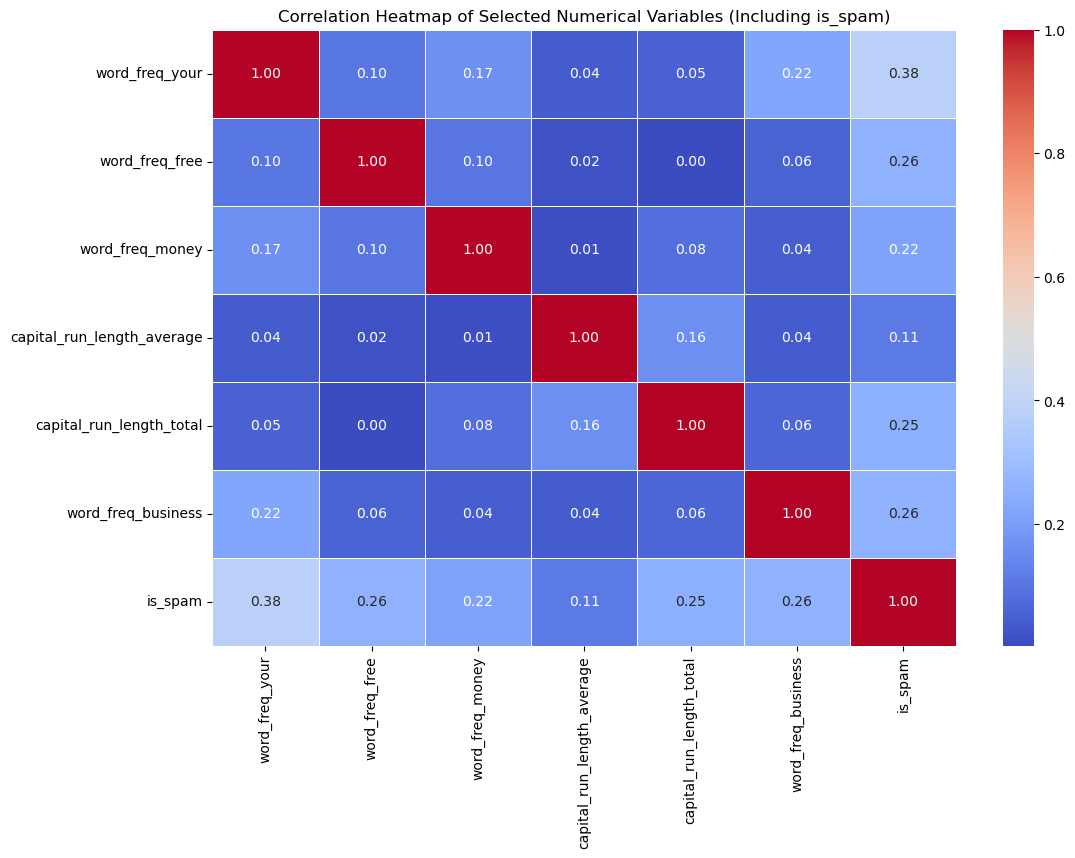

In [121]:

# Ensure 'is_spam' is numeric
df['is_spam'] = df['is_spam'].astype(int)

# Selected numerical variables + target variable
selected_vars = ["word_freq_your", "word_freq_free", "word_freq_money", "capital_run_length_average", 
                 "capital_run_length_total", "word_freq_business", "is_spam"
]

# Compute correlation matrix
correlation_matrix = df[selected_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Title
plt.title("Correlation Heatmap of Selected Numerical Variables (Including is_spam)")
plt.show()

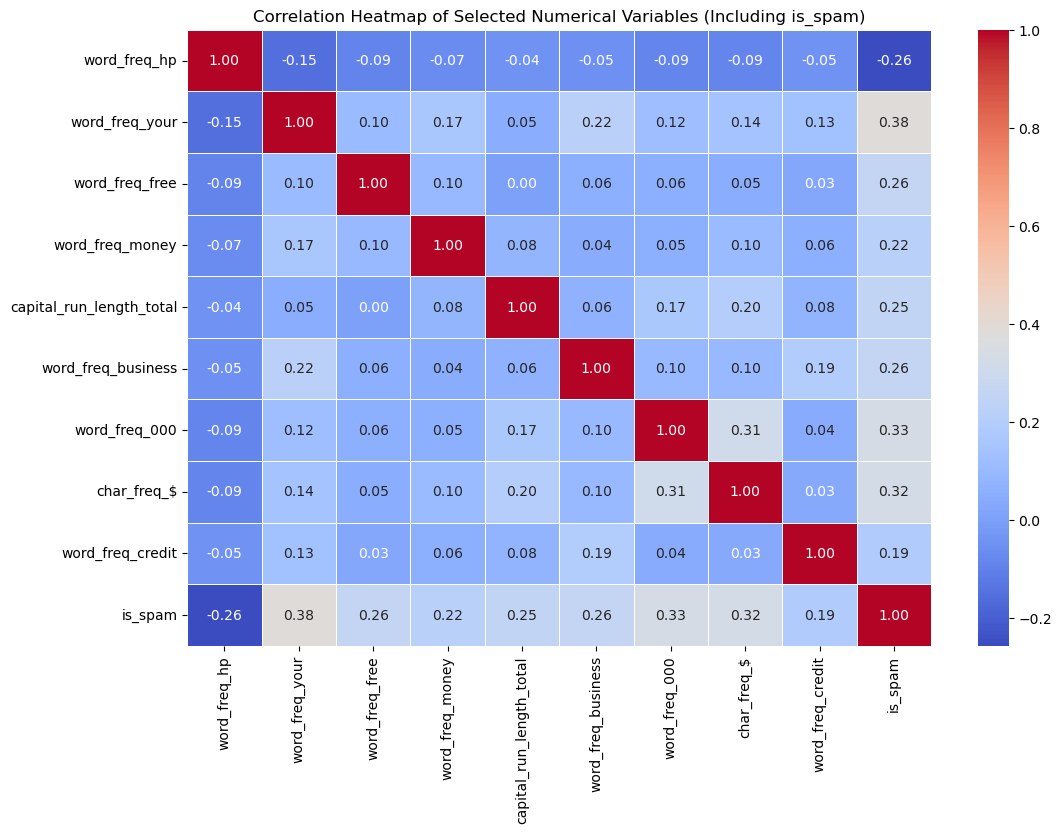

In [134]:
# Ensure 'is_spam' is numeric
df['is_spam'] = df['is_spam'].astype(int)

# Selected numerical variables + target variable
selected_vars = ["word_freq_hp", "word_freq_your", "word_freq_free", "word_freq_money", 
                 "capital_run_length_total", "word_freq_business","word_freq_000", "char_freq_$", "word_freq_credit", 
                 "is_spam"
]

# Compute correlation matrix
correlation_matrix = df[selected_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Title
plt.title("Correlation Heatmap of Selected Numerical Variables (Including is_spam)")
plt.show()

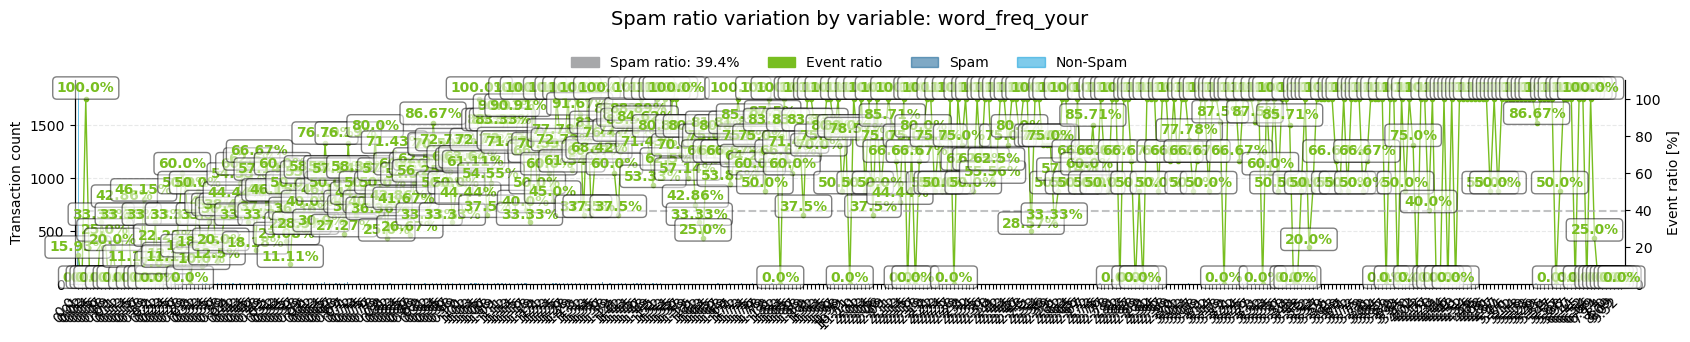

In [150]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_your',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [152]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_your_bin"] = pd.qcut(df['word_freq_your'], q=num_bins, duplicates='drop')

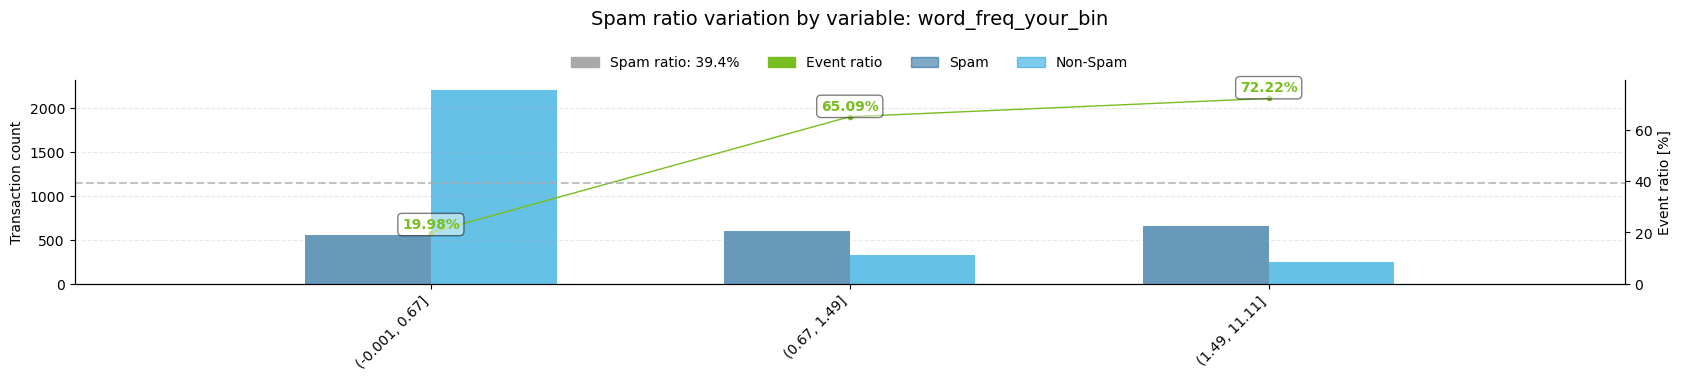

In [153]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_your_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [154]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_000_bin"] = pd.qcut(df['word_freq_000'], q=num_bins, duplicates='drop')

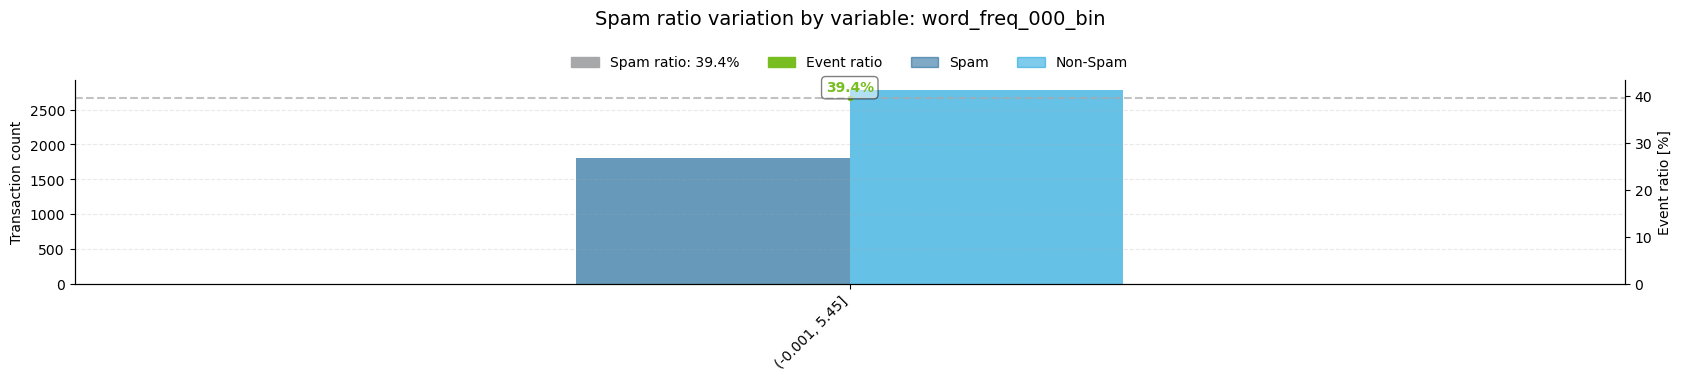

In [155]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_000_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [159]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_credit_bin"] = pd.qcut(df['word_freq_credit'], q=num_bins, duplicates='drop')

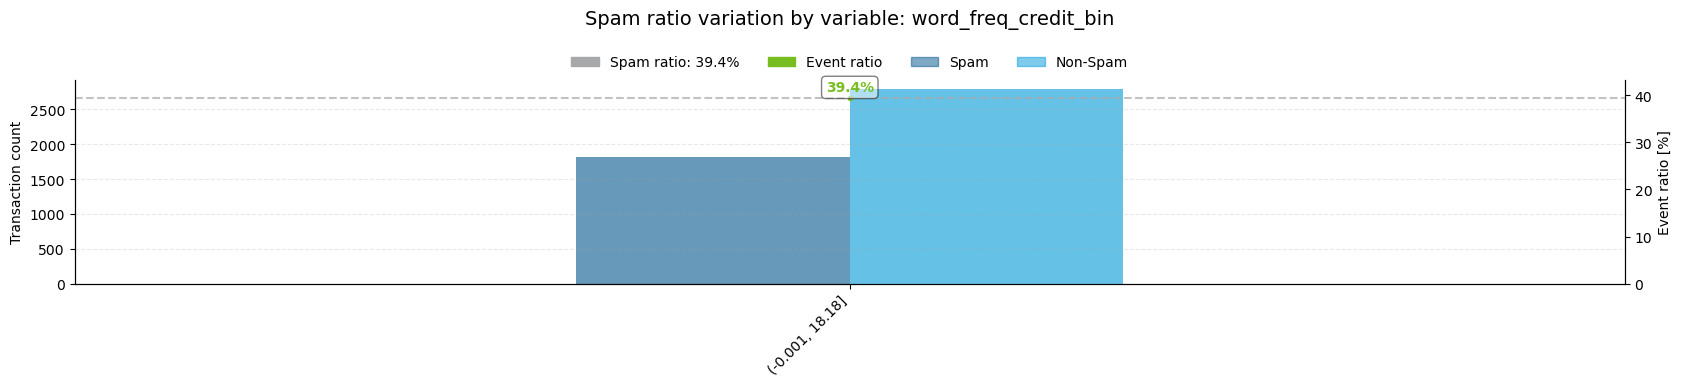

In [160]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_credit_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [164]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_money_bin"] = pd.qcut(df['word_freq_money'], q=num_bins, duplicates='drop')

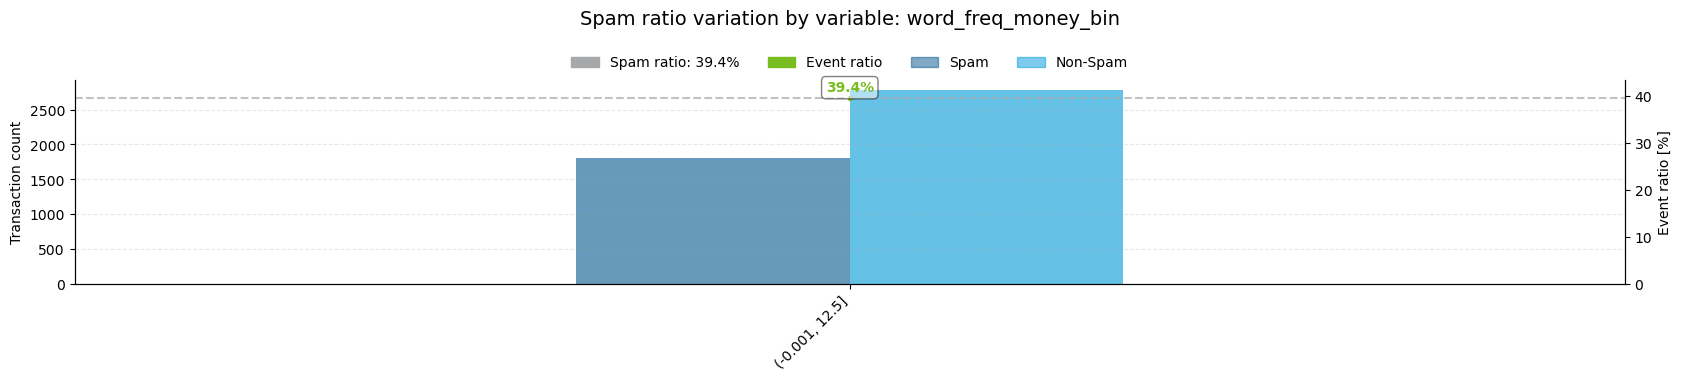

In [165]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_money_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [166]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_business_bin"] = pd.qcut(df['word_freq_business'], q=num_bins, duplicates='drop')

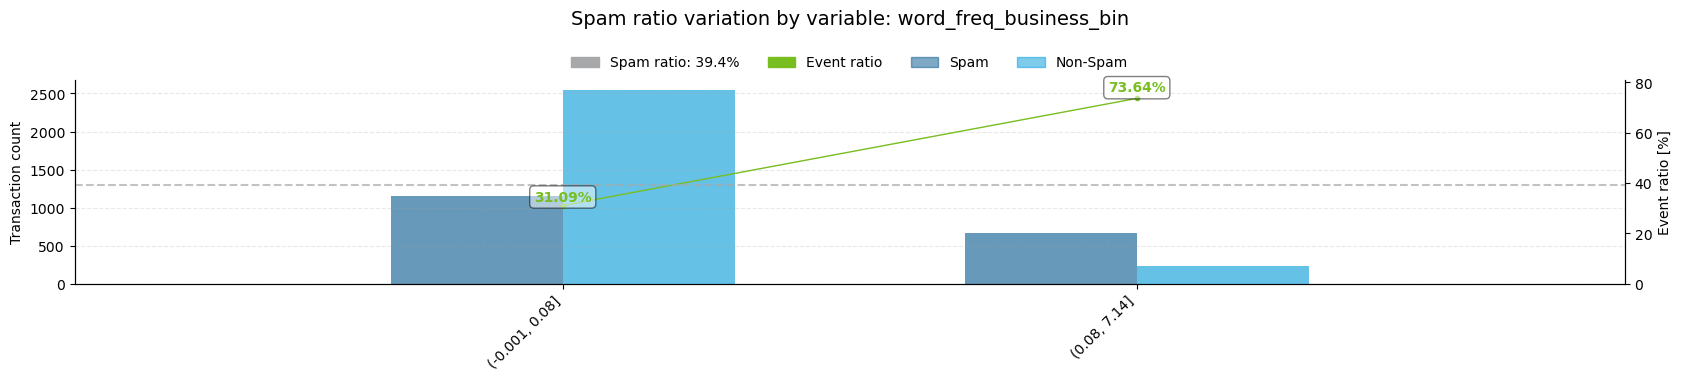

In [167]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_business_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [187]:
num_bins = 10  # 5 bins to represent quartiles, can be changed to better interpret the data
df["capital_run_length_total_bin"] = pd.qcut(df['capital_run_length_total'], q=num_bins, duplicates='drop')

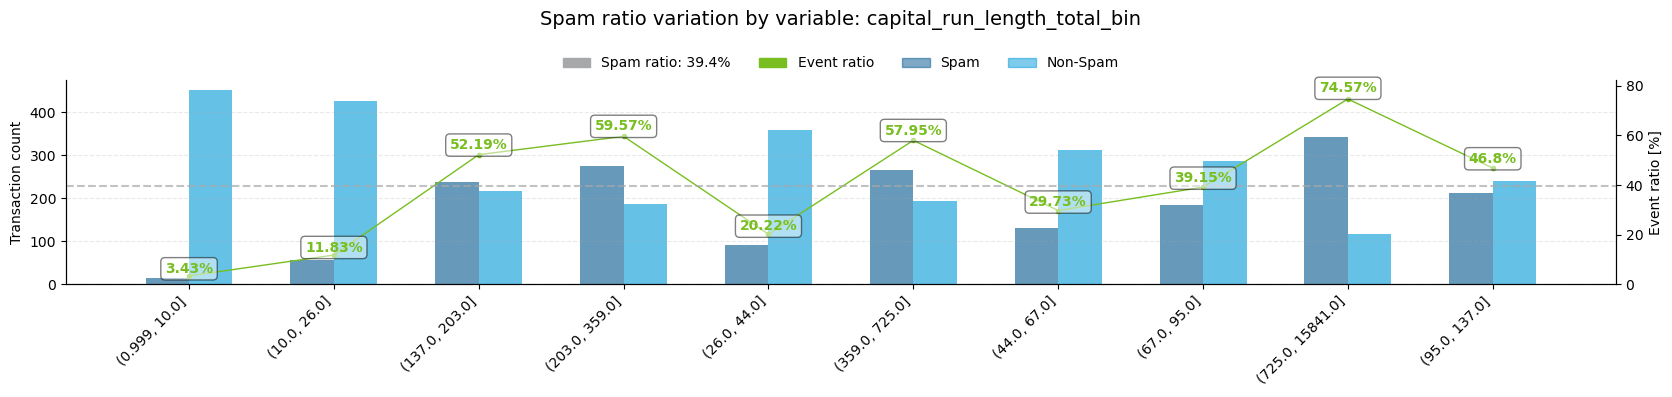

In [193]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='capital_run_length_total_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [176]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["char_freq_$_bin"] = pd.qcut(df['char_freq_$'], q=num_bins, duplicates='drop')

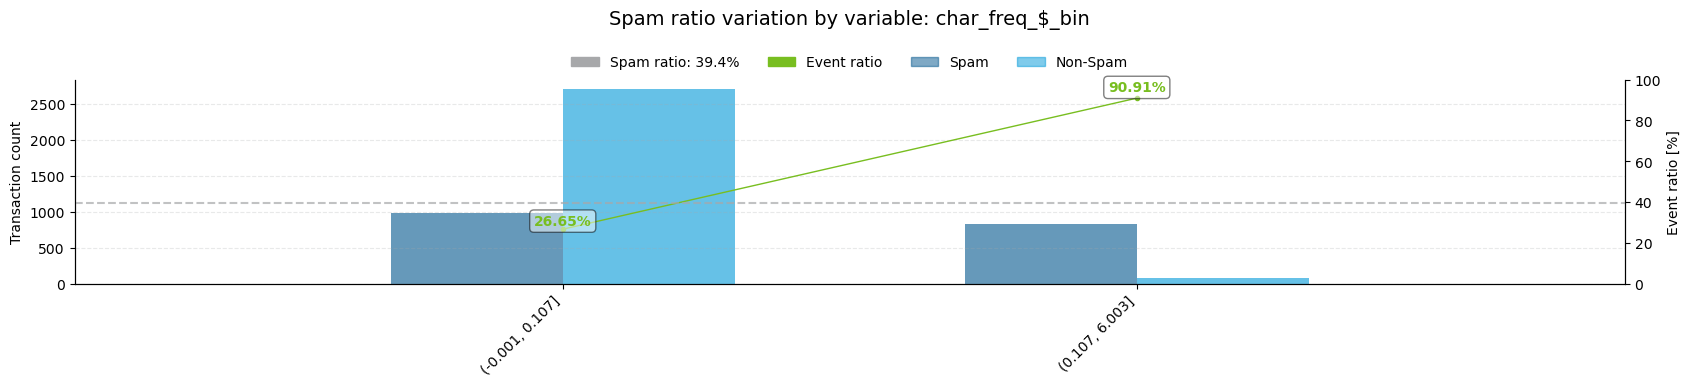

In [177]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='char_freq_$_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [180]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_hp_bin"] = pd.qcut(df['word_freq_hp'], q=num_bins, duplicates='drop')

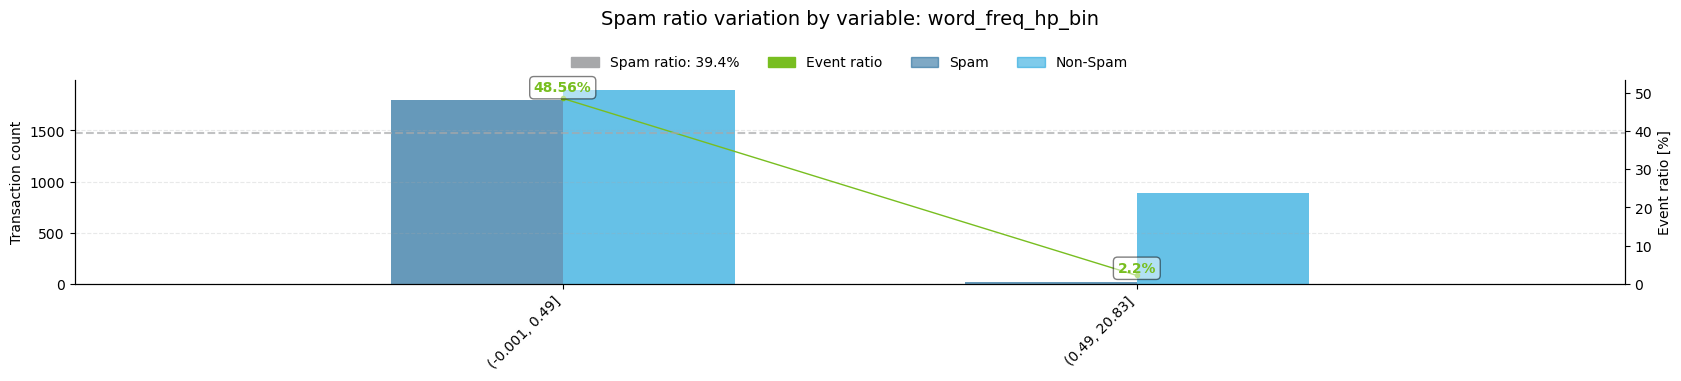

In [181]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_hp_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [194]:
# Example: Define specific columns to check
columns_to_check = ["char_freq_$", "word_freq_000", "word_freq_business", 
                    "capital_run_length_total", "word_freq_hp", "word_freq_money"]

# Check for NaN values in the specified columns
nan_counts = df[columns_to_check].isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

char_freq_$                 0
word_freq_000               0
word_freq_business          0
capital_run_length_total    0
word_freq_hp                0
word_freq_money             0
dtype: int64
